In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as datetime


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
print("Measurement Table -name and var type")
for c in columns:
    print(c['name'], c["type"])

print("Station Table -name and var type")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])    
   

Measurement Table -name and var type
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Station Table -name and var type
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

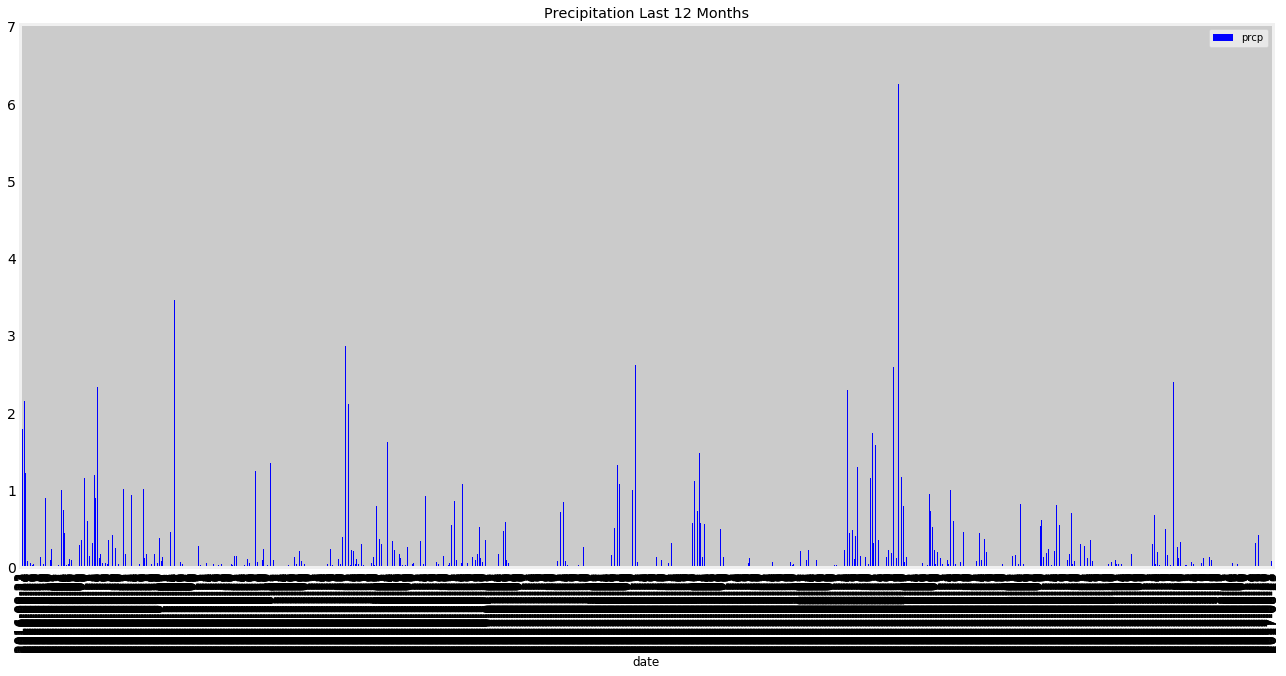

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

results = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp).\
    order_by(Measurement.date).all() #brings in a tuple 
#print(results)
# LETS grab the last date and subtract %%% day 3 squalchemy towards end 
#query.(Model).filter(something)[:5].all() query.(Model).filter(something).limit(5).all() 

measure_df = pd.DataFrame(results) # make it a dataframe!

#one_year=measure_df.iloc[1,3]
#two_year=measure_df.iloc[2,3]

last_date_row= measure_df['date'].count()
last_date_row
last_date=measure_df.iloc[last_date_row-1, 2]


datetime_obj=datetime.datetime.strptime(last_date, '%Y-%m-%d')
start_date=(datetime_obj.date() - datetime.timedelta(days=365)) 

#precip_query=session.query(Measurement.date).\
#    order_by(Measurement.date.desc()).limit(1).all() #brings in a tuple

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all() #brings in a tuple 

#new data frame for the plot 
precip_df = pd.DataFrame(results) 

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df.set_index('date')  #make date the index
precip_df=precip_df.dropna();


# Sort the dataframe by date- did that on the original query

# Use Pandas Plotting with Matplotlib to plot the data
precip=precip_df.groupby('date').agg(np.mean)  # this one makes more sense IMO


precip_df.plot(kind='bar', x=0,y='prcp', color='blue', title='Precipitation Last 12 Months', grid=True, fontsize=14, figsize=(20, 10)) #,x='date'
plt.show() #the above one works!!! 
#above works just commented it out for speed 

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
temperature_df=precip_df.drop(['prcp'], axis=1)
#precip_df.drop['tobs'] 
precip_df=precip_df.drop(['tobs'], axis=1)
precip_df.describe()

precip_df=precip_df.sort_values(['date'])


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset? 
number_stations = session.query(Station.station).count()#.\
number_stations

9

In [13]:
station = session.query(Station.id,Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
     order_by(Station.name).all() #brings in a tuple 
station_df = pd.DataFrame(station) #maybe make this np.array() ?  

join = session.query(Measurement, Station).filter(Measurement.station==Station.station).limit(10).all() #\

join_df = pd.merge(station_df, precip_df, on='station', how='inner') 

# What are the most active stations? (i.e. what stations have the most rows)?
busy_station=join_df['station'].value_counts() #count number rows for each station

# List the stations and the counts in descending order.
#print(busy_station.sort_values(ascending=False))
busy_station= busy_station.sort_values(ascending=False)
print(busy_station) # which station has the highest number of observations? 
busiest_station= busy_station.index[0]



USC00519397    359
USC00519281    352
USC00513117    343
USC00516128    328
USC00519523    314
USC00514830    265
USC00517948     60
Name: station, dtype: int64


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
busiest_station_df=join_df[join_df['station']==busiest_station]
print(busiest_station_df['tobs'].max())

# highest temperature recorded, and average temperature most active station?
print(busiest_station_df['tobs'].min())
print(busiest_station_df['tobs'].mean())

KeyError: 'tobs'

In [ ]:
# Choose the station with the highest number of temperature observations.
temp_obs=join_df[['station', 'tobs','date']] 
#print(temp_obs)
temp_obs_busiest=temp_obs['station'].value_counts() #count number rows for each station
temp_obs_busiest_station= temp_obs_busiest.index[0] #busiest station assigned to variable 
print(temp_obs_busiest_station)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs=temp_obs[temp_obs['station'] == temp_obs_busiest_station]
#temp_obs.sort_values('date')  #we have already done the query for last twelve months 
temp_obs

temp_obs.plot(kind='hist',x='date', y='tobs', bins=12, color='blue', title='Precipitation Last 12 Months', grid=True, fontsize=16, figsize=(20, 10))
#plt.show() #the above one works!!! 



![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
temps, = calc_temps('2012-02-28', '2012-03-05') #the, is to unpack the tuple

In [ ]:
temps, = calc_temps('2017-08-03', '2017-08-10') #the, is to unpack the tuple
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
print(temps)
tmin, tavg, tmax = temps



In [ ]:
# Plot the results from your previous query as a bar chart. 

plt.rc('axes',titlesize=20)  # did nothing but keeping in case we add something    
plt.rc('ytick',labelsize=20) # did the y tick labels 
plt.rc('xtick',labelsize=1)  # x label size 
plt.rc('figure',titlesize=30)  # not sure what this did 
plt.rc('legend',fontsize=30)  # no legend but just in case we add
plt.figure(figsize=(5,10))
plt.xticks([10])

plt.ylabel("Trip Average Temperature (F)", size=24, fontname='arial')
plt.xlabel("Aug 3-10, 2017")


plt.bar(1,tavg, color="red", width= 0.3, yerr=(tmax-tmin),align='center')
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
#print(join_df)
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
trip_obs= join_df[join_df['date'] >= '2017-08-03'] 
trip_obs= trip_obs[trip_obs['date'] <='2017-08-10']
trip_obs=trip_obs.groupby(['station','name']).sum()

trip_obs.sort_values('prcp', ascending=False)
#trip_obs.head()

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#print(trip_obs.head())
trip_obs[['latitude','longitude','elevation','tobs']]
        

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
import json
import pprint
import flask

# 1. import Flask
from flask import Flask, jsonify
# 2. Create an app, being sure to pass __name__
app = Flask(__name__)
app.config['JSONIFY_PRETTYPRINT_REGULAR'] = True  #enabling pretty printing of json

precip= "/api/v1.0/precipitation -   to see JSON of available precipitation data<br/>"
temp= "/api/v1.0/tobs -  to see JSON temperature observations<br/>"
start="/api/v1.0/year_temp/<start> -   JSON list of temp observations for 12 months from <start> date in MM-DD-YYYY format<br/>"
start_end="/api/v1.0/temp_history/<start>/<end> -   JSON list of temp observations for 12 months from <start> date to <end> date in MM-DD-YYYY format<br/>"
stations="/api/v1.0/stations -  for a JSON list of available weather stations and their location"
options="Welcome to Climate Observations! <br/><br/>Available URL options are:<br/>"+precip+temp+start+start_end+stations

def temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
        Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns: TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#temps, = calc_temps('2012-02-28', '2012-03-05') #the, is to unpack the tuple
# 3. Define what to do when a user hits the index route

# List all routes that are available.
@app.route("/")
def home():
    print("Server received request for 'Home' page...")
    return options

#Return a JSON list of the min temp, the avg temp, and the max temp for one year stating at the <start> date
@app.route("/api/v1.0/year_temp/<start>")
def twelve_months_temp(start):
    session = Session(engine)
    datetime_obj=datetime.datetime.strptime(start, '%Y-%m-%d')
    end=(datetime_obj.date() + datetime.timedelta(days=365)) 
    one_year,= temps(start, end)
    return one_year

# query for the dates and temperature observations from a year from the last data point.
@app.route("/api/v1.0/precipitation")  
def precipitation():
    session = Session(engine)
    precip_dict=precip_df.to_dict()
    #output=json.dumps(precip_dict, indent=2)
    output=jsonify(precip_dict)
    return output 

# Return a JSON list of stations from the dataset.
@app.route("/api/v1.0/stations")
def station():
    session = Session(engine)
    station_dict=station_df.to_dict()
    #output=str(json.dumps(station_dict, indent=2))
    output= jsonify(station_dict)
    return output

# Return a JSON list of Temperature Observations (tobs) for the previous year.
@app.route("/api/v1.0/tobs")
def temp():
    session = Session(engine)
    temp_dict=temperature_df.to_dict()
    output=jsonify(temp_dict)
    return output

#Return a JSON list of the min temp, the avg temp, and the max temp for a date range bound by <start> and <end> date
@app.route("/api/v1.0/temp_history/<start>/<end>")
def date_end(start, end):
    session = Session(engine)
    start_end, = temps(start, end)
    return start_end

if __name__ == "__main__":
    app.run(debug=False)
    